In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions_anisotropy import *
from scipy.linalg import null_space

### Inversion for the elastic tensor 

author: Sebastian Noe, snoe@geophysik.uni-muenchen.de

We use single station 6C data. Assumptions include: no boundary conditions, homogeneous medium, known density and the propagation direction $\nu$ is constant for all three arriving wavefronts.

The inversion is only possible if p-wave curl is observed. This means that it is not possible to invert for isotropic media. 

It is possible to estimate the polarization vectors and the corresponding phase velocities. They are the solution of the eigenproblem for the Kristoffel Matrix $\Gamma = LCL^T$, where $C$ is a $6\times6$ matrix containing all elastic parameters (Voigt notation) and L a direction-dependent transformation matrix such that $\Gamma_{i,l} = \nu_j\nu_kc_{ijkl}$.  

With estimated eigenvalues and eigenvectors, one can calculate the Kristoffel matrix.

$
\Gamma = N^T V N
$

In our inversion, the Kristoffel matrix represents the data vector.

$
d = \begin{pmatrix}\Gamma_{11}&\Gamma_{22}&\Gamma_{33}&\Gamma_{12}&\Gamma_{13}&\Gamma_{23} \end{pmatrix}^T
$

The model vector we want to invert for is 

$
m = \begin{pmatrix} C_{11}&C_{22}&C_{33}&C_{12}&C_{13}&C_{23}&C_{14}&C_{25}&C_{36}&C_{15}&C_{16}&C_{24}&C_{26}&C_{34}&C_{35}&C_{44}&C_{55}&C_{66}&C_{45}&C_{46}&C_{56} \end{pmatrix}^T
$

According to this convention, we can set up the direction dependencies for each parameters to get the $6\times21$ matrix

<font size="1.5">
    
$
g = \begin{pmatrix}\nu_1^2&0&0&0&0&0&0&0&0&2\nu_1\nu_3&2\nu_1\nu_2&0&0&0&0&0&\nu_3^2&\nu_2^2&0&0&2\nu_2\nu_3 \\
0&\nu_2^2&0&0&0&0&0&0&0&0&0&2\nu_2\nu_3&2\nu_1\nu_2&0&0&\nu_3^2&0&\nu_1^2&0&2\nu_1\nu_3&0 \\
0&0&\nu_3^2&0&0&0&0&0&0&0&0&0&0&2\nu_2\nu_3&2\nu_1\nu_2&\nu_2^2&\nu_1^2&0&2\nu_1\nu_2&0&0 \\ 
0&0&0&\nu_1\nu_2&0&0&\nu_1\nu_3&\nu_2\nu_3&0&0&\nu_1^2&0&\nu_2^2&0&0&0&0&\nu_1\nu_2&\nu_3^2&2\nu_2\nu_3&\nu_1\nu_3\\ 0&0&0&0&\nu_1\nu_3&0&\nu_1\nu_2&0&\nu_2\nu_3&\nu_1^2&0&0&0&0&\nu_3^2&0&\nu_1\nu_3&0&\nu_2\nu_3&\nu_2^2&\nu_1\nu_2 \\ 0&0&0&0&0&\nu_2\nu_3&0&\nu_1\nu_2&\nu_1\nu_3&0&0&\nu_2^2&0&\nu_3^2&0&\nu_2\nu_3&0&0&\nu_1\nu_3&\nu_1\nu_2&\nu_1^2 \end{pmatrix}$
</font>

such that the system

$
d = g m
$

must be solved. With a single measurement, the solution is underdetermined. To add more measurements, the rows are extended while the number of columns is kept constant. After taking multiple events into account, the inversion is overdetermined and thus feasible. This can be found in the dimension of the nullspace of $g$. If the nullspace has a dimension over zero, one can change the model along the nullspace without improvement of the data. 

The full inversion for 21 elastic constants follows the system of

| number of events | 1  | 2 |3 |4 |5 |6|
|------|------|------|------|------|------|------|
|   dim of nullspace  | 15|10|6|3|1|0|

To solve unambiguously for 21 elastic parameters **6** distinct events are necessary. Further events may be used to reduce the impact of noise (not yet implemented in code).


### Assume symmetry systems

It is possible to invert for the best fit of a certain symmetry systems. Accordingly, not all 21 parameters need to be inverted for, e.g. for VTI 5 parameters suffice. The number of columns of $g$ can be reduced. This also has the effect that less events are necessary to archieve a trivial nullspace. For example, just 2 events are necessary to invert for VTI-media.

### Misfit calculation

In order to evaluate the error of the inversion, it's possible to use the estimated elastic tensor for a synthetic calculation and subsequently compare synthetic data set with the observed one. The frequency carrying the most energy has to be known.




__Cell 1:__

The defined function here adds new data to the data vector and the to the matrix g. Depending on the assumed underlying symmetry system, the matrix g is chosen. Entries for d (=$\Gamma$) are calculated by rotating the diagonal matrix of eigenvalues ($=\rho v^2$) according to the polarizations.

In [2]:
def add_new_data(mode,d,g,nu_e,vel_e,n_trans,density):
    d = list(d)
    g = list(g)
    QT = np.array(n_trans)
    Q = QT.transpose()
    if np.shape(Q)==(3,3):
        D = density * np.array([[vel_e[0]**2,0,0],[0,vel_e[1]**2,0],[0,0,vel_e[2]**2]])
        GAMMA = np.dot(np.dot(Q,D),QT)
        d.extend([GAMMA[0,0],GAMMA[1,1],GAMMA[2,2],GAMMA[0,1],GAMMA[0,2],GAMMA[1,2]])
        if mode=='triclinic':
            GT = np.array([    [nu_e[0]**2,0,0,0,0,0],\
                               [0,nu_e[1]**2,0,0,0,0],\
                               [0,0,nu_e[2]**2,0,0,0],\
                               [0,0,0,nu_e[0]*nu_e[1],0,0],\
                               [0,0,0,0,nu_e[0]*nu_e[2],0],\
                               [0,0,0,0,0,nu_e[1]*nu_e[2]],\
                               [0,0,0,nu_e[0]*nu_e[2],nu_e[0]*nu_e[1],0],\
                               [0,0,0,nu_e[1]*nu_e[2],0,nu_e[0]*nu_e[1]],\
                               [0,0,0,0,nu_e[1]*nu_e[2],nu_e[0]*nu_e[2]],\
                               [2*nu_e[0]*nu_e[2],0,0,0,nu_e[0]**2,0],\
                               [2*nu_e[0]*nu_e[1],0,0,nu_e[0]**2,0,0],\
                               [0,2*nu_e[1]*nu_e[2],0,0,0,nu_e[1]**2],\
                               [0,2*nu_e[0]*nu_e[1],0,nu_e[1]**2,0,0],\
                               [0,0,2*nu_e[1]*nu_e[2],0,0,nu_e[2]**2],\
                               [0,0,2*nu_e[0]*nu_e[2],0,nu_e[2]**2,0],\
                               [0,nu_e[2]**2,nu_e[1]**2,0,0,nu_e[1]*nu_e[2]],\
                               [nu_e[2]**2,0,nu_e[0]**2,0,nu_e[0]*nu_e[2],0],\
                               [nu_e[1]**2,nu_e[0]**2,0,nu_e[0]*nu_e[1],0,0],\
                               [0,0,2*nu_e[0]*nu_e[1],nu_e[2]**2,nu_e[1]*nu_e[2],nu_e[0]*nu_e[2]],\
                               [0,2*nu_e[0]*nu_e[2],0,nu_e[1]*nu_e[2],nu_e[1]**2,nu_e[0]*nu_e[1]],\
                               [2*nu_e[1]*nu_e[2],0,0,nu_e[0]*nu_e[2],nu_e[0]*nu_e[1],nu_e[0]**2]
                      ])
            G = GT.transpose()
        elif mode=='cubic':
            G = np.array([[nu_e[0]**2,0,nu_e[1]**2+nu_e[2]**2],\
                          [nu_e[1]**2,0,nu_e[0]**2+nu_e[2]**2],\
                          [nu_e[2]**2,0,nu_e[0]**2+nu_e[1]**2],\
                          [0,nu_e[0]*nu_e[1],nu_e[0]*nu_e[1]],\
                          [0,nu_e[0]*nu_e[2],nu_e[0]*nu_e[2]],\
                          [0,nu_e[1]*nu_e[2],nu_e[1]*nu_e[2]]
                         ])
        
        elif mode=='VTI':
            G = np.array([[nu_e[0]**2,0,0,nu_e[2]**2,nu_e[1]**2],\
                       [nu_e[1]**2,0,0,nu_e[2]**2,nu_e[0]**2],\
                       [0,nu_e[2]**2,0,nu_e[0]**2+nu_e[1]**2,0],\
                       [nu_e[0]*nu_e[1],0,0,0,-nu_e[0]*nu_e[1]],\
                       [0,0,nu_e[0]*nu_e[2],nu_e[0]*nu_e[2],0],\
                       [0,0,nu_e[1]*nu_e[2],nu_e[1]*nu_e[2],0]
                        ])
        elif mode=='tetragonal':
            G = np.array([[nu_e[0]**2,0,0,0,nu_e[2]**2,nu_e[1]**2],\
                          [nu_e[1]**2,0,0,0,nu_e[2]**2,nu_e[0]**2],\
                          [0,nu_e[2]**2,0,0,nu_e[0]**2+nu_e[1]**2,0],\
                          [0,0,nu_e[0]*nu_e[1],0,0,nu_e[0]*nu_e[1]],\
                          [0,0,0,nu_e[0]*nu_e[2],nu_e[0]*nu_e[2],0],\
                          [0,0,0,nu_e[1]*nu_e[2],nu_e[1]*nu_e[2],0]
                         ])
        elif mode=='trigonal':
            G = np.array([[nu_e[0]**2,0,0,2*nu_e[1]*nu_e[2],nu_e[2]**2,nu_e[1]**2],\
                          [nu_e[1]**2,0,0,-2*nu_e[1]*nu_e[2],nu_e[2]**2,nu_e[0]**2],\
                          [0,nu_e[2]**2,0,0,nu_e[0]**2+nu_e[1]**2,0],\
                          [nu_e[0]*nu_e[1],0,0,2*nu_e[0]*nu_e[2],0,-nu_e[0]*nu_e[1]],\
                          [0,0,nu_e[0]*nu_e[2],2*nu_e[0]*nu_e[1],nu_e[0]*nu_e[2],0],\
                          [0,0,nu_e[1]*nu_e[2],nu_e[0]**2-nu_e[1]**2,nu_e[1]*nu_e[2],0]\
                         ])
        elif mode=='orthorhombic':
            G = np.array([[nu_e[0]**2,0,0,0,0,0,0,nu_e[2]**2,nu_e[1]**2],\
                          [0,nu_e[1]**2,0,0,0,0,nu_e[2]**2,0,nu_e[0]**2],\
                          [0,0,nu_e[2]**2,0,0,0,nu_e[1]**2,nu_e[0]**2,0],\
                          [0,0,0,nu_e[0]*nu_e[1],0,0,0,0,nu_e[0]*nu_e[1]],\
                          [0,0,0,0,nu_e[0]*nu_e[2],0,0,nu_e[0]*nu_e[2],0],\
                          [0,0,0,0,0,nu_e[1]*nu_e[2],nu_e[1]*nu_e[2],0,0]\
                         ])
        g.extend(G)
    return np.array(d), np.array(g)

__Cell 2:__

In order to set up the inverse problem, the 6x6 matrix of elastic parameters is written as a vector with 21 dimensions. In this function, the model vector is sorted back into a 6 by 6 matrix. It dependends on the assumed symmetry system.

In [3]:
def sort_elastic_coeff(mode,m):
    C = np.zeros((6,6))
    if mode=='triclinic':
        C[0,0] = m[0] 
        C[1,1] = m[1]
        C[2,2] = m[2]
        C[0,1] = m[3]
        C[0,2] = m[4]
        C[1,2] = m[5]
        C[0,3] = m[6]
        C[1,4] = m[7]
        C[2,5] = m[8]
        C[0,4] = m[9]
        C[0,5] = m[10]
        C[1,3] = m[11]
        C[1,5] = m[12]
        C[2,3] = m[13]
        C[2,4] = m[14]
        C[3,3] = m[15]
        C[4,4] = m[16]
        C[5,5] = m[17]
        C[3,4] = m[18]
        C[3,5] = m[19]
        C[4,5] = m[20]
    elif mode=='cubic':
        C[0,0] = m[0]
        C[1,1] = m[0]
        C[2,2] = m[0]
        C[0,1] = m[1]
        C[0,2] = m[1]
        C[1,2] = m[1]
        C[3,3] = m[2]
        C[4,4] = m[2]
        C[5,5] = m[2]
    elif mode=='VTI':
        C[0,0] = m[0]
        C[1,1] = m[0]
        C[2,2] = m[1]
        C[0,2] = m[2]
        C[1,2] = m[2]
        C[3,3] = m[3]
        C[4,4] = m[3]
        C[5,5] = m[4]
        C[0,1] = C[1,1]-2*C[5,5]
    elif mode=='tetragonal':
        C[0,0] = m[0]
        C[1,1] = m[0]
        C[2,2] = m[1]
        C[0,1] = m[2]
        C[0,2] = m[3]
        C[1,2] = m[3]
        C[3,3] = m[4]
        C[4,4] = m[4]
        C[5,5] = m[5]   
    elif mode=='trigonal':
        C[0,0] = m[0]
        C[1,1] = m[0]
        C[2,2] = m[1]
        C[0,2] = m[2]
        C[1,2] = m[2]
        C[0,3] = m[3]
        C[1,3] = - C[0,3]
        C[3,3] = m[4]
        C[4,4] = m[4]
        C[4,5] = C[0,3]
        C[5,5] = m[5]
        C[0,1] = C[1,1]-2*C[5,5]
    elif mode=='orthorhombic':
        C[0,0] = m[0]
        C[1,1] = m[1]
        C[2,2] = m[2]
        C[0,1] = m[3]
        C[0,2] = m[4]
        C[1,2] = m[5]
        C[3,3] = m[6]
        C[4,4] = m[7]
        C[5,5] = m[8]
                       
    for i in range(0,6):
        for j in range(i,6):
            C[j,i] = C[i,j]      
    return C        
    

__Cell 3:__

Here, the misfit $\chi$ is calculated. It takes the full waveform into account. 

$
\chi = \sum_k  \frac{1}{A_k} \sum_i (d(k,t_i) - d_{syn}(k,t_i))^2
$

k declares the component ($k={1,2,3,4,5,6}$) of 6C measurement, A is the maximum amplitude of the component and serves as a normalization to make offsets on different component types comparable.

The synthetic dataset is gained with a forward solver using the estimated elastic tensor. Frequency is assumed to be known.

In [4]:
def get_misfit(seis,t,nu,C_e, f, density,fs):
    gammas_syn = get_gamma(nu, C_e)
    misfits = []
    for j in range(0,len(nu)):
        vel_syn, v_syn = get_eigenvals(gammas_syn[j], density)
        seis_syn, t_syn = get_seis(v_syn,vel_syn,nu[j],f,fs)
        misfit = 0
        nt = min(len(t_syn),len(t))
        for k in range(0,6):
            amax = max(seis[j][k,:])
            for it in range(0,nt):
                misfit += ((seis_syn[k,it]-seis[j][k,it])/amax)**2
        misfits.append(misfit)        
    return misfits         

In [5]:
medium = load_medium_list()
print(' ')
random_medium = load_random_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz
 
#0 isotropic
#1 cubic
#2 VTI
#3 tetragonal
#4 trigonal
#5 orthorhombic
#6 monoclinic
#7 triclinic


In [6]:
index = 5
C, density = get_specific_VTI(medium[index],give_thomsen=True)
#C, density = get_random_C(random_medium[index],50)

mesaverde calcareous sandstone
 
vp0     = 5460
vs0     = 3219
eps     = 0.0
delta   = -0.264
gamma   = -0.007
density = 2690
 
[[80.193204   25.22631672 -5.02593998  0.          0.          0.        ]
 [25.22631672 80.193204   -5.02593998  0.          0.          0.        ]
 [-5.02593998 -5.02593998 80.193204    0.          0.          0.        ]
 [ 0.          0.          0.         27.87367509  0.          0.        ]
 [ 0.          0.          0.          0.         27.87367509  0.        ]
 [ 0.          0.          0.          0.          0.         27.48344364]]


__Cell 4:__

The experiment is executed in this cell. The used frequency acts as a constant throught all recorded events. $N$ gives the number of said events. Each event will come from a different direction, i.e. will show variations in phase velocity. The option _mode_ gives the assumed symmetry. To invert for the general case of 21 independent elastic constant, use 'triclinic'. Other possible options are,ascending in number of unknowns, 'cubic', 'VTI', 'trigonal', 'tetragonal' and 'orthorhombic'.

The inversion works fine whenever all velocities are correctly estimated - estimated and true values are shown to trace potential errors. 



C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:480: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, projection='stereonet')


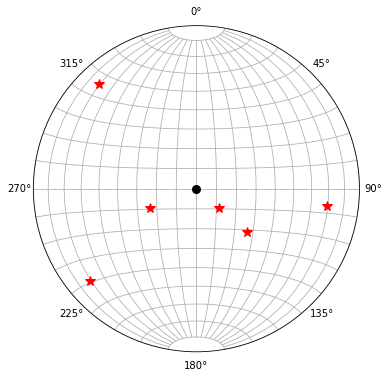

#1
Nullspace dimension: 15
True velocities
5367.925845453618 [3370.3016360128777, 3197.8444342603957]
Estimated velocities
[5367.925845453613, 3370.301636012906, 3197.844429444684]
 
#2
Nullspace dimension: 10
True velocities
5386.70959572511 [3340.1977084183254, 3197.545711061155]
Estimated velocities
[5386.7095957250995, 3340.197324284338, 3197.5452196219444]
 
#3
Nullspace dimension: 6
True velocities
5367.8585921096765 [3370.4087489671497, 3217.5516574120675]
Estimated velocities
[5367.858592109692, 3370.4085828288917, 3217.5515165875986]
 
#4
Nullspace dimension: 3
True velocities
5286.382801151631 [3496.815391136373, 3199.1562200337526]
Estimated velocities
[5286.38280115161, 3496.815391136373, 3199.1562200337526]
 
#5
Nullspace dimension: 1
True velocities
5201.61630970404 [3621.7052291180357, 3214.848390236226]
Estimated velocities
[5201.616309704044, 3621.7052291180344, 3214.8483902362254]
 
#6
Nullspace dimension: 0
True velocities
5051.74686058517 [3827.9778808880146, 3212.0

C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:1002: ComplexWarning: Casting complex values to real discards the imaginary part
  eigv[k] = v[:,l]


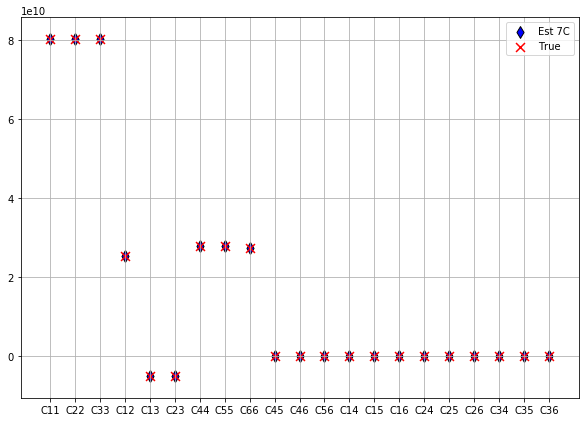

In [7]:
f = 10.
fs = 100.
N = 6
## mode: assumed symmetry
mode = 'triclinic'

d = np.array([])
G = np.array([])
C_e = np.zeros((6,6))
misfits = []
nus, gammas = get_direction('random',C,N+2,theta_e=0.,phi_e=0.)
plot_directions(nus[1:N+1])

all_nu_e = []
all_seis = []
all_t = []
for i in range(1,N+1):
    vel, v = get_eigenvals(gammas[i], density)
    seis, t = get_seis(v,vel,nus[i],f,fs) 
    all_seis.append(seis)
    all_t.append(t)
    
    n_trans = get_polarizations(seis,'trans')
    nu_e = get_propagation_direction(seis)
    all_nu_e.append(nu_e)
    vel_e,_,_ = estimate_velocity(seis,nu_e,t)        
    
    d,G = add_new_data(mode,d,G,nu_e,vel_e,n_trans,density)
    m = np.dot(np.dot(np.linalg.inv(np.dot(G.transpose(),G)),G.transpose()),d)
    C_e = sort_elastic_coeff(mode,m)
    print('#'+str(i))
    print('Nullspace dimension: '+str(np.shape(null_space(G))[1]))
    print('True velocities')
    print(max(vel),extract_slower_velocities(vel))
    print('Estimated velocities')
    print(vel_e)
    print(' ')  
    if np.shape(null_space(G))[1]==0:
        N_shots = i-1
        print('Estimated Elastic tensor:')
        print(C_e[:3,:3]*1e-9)
        print(C_e[:3,3:]*1e-9)
        print(C_e[3:,3:]*1e-9)
        misfit = get_misfit(all_seis,all_t,all_nu_e,C_e, f, density,fs)
        print(' ')
        print('Average misfit:')
        print(np.mean(misfit))
        print(' ')
                   
    
print('Accurate Elastic tensor:')
print(C[:3,:3]*1e-9)
print(C[:3,3:]*1e-9)
print(C[3:,3:]*1e-9)
print(' ')     

plot_tensor_estimation(C,C_e)